# Introduction of dataset

In [1]:
import os, sys
import numpy as np
import h5py
import sigpy as sp
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

import sigpy.plot as pl

In [2]:
# location of the dset : /mnt/dense/kanghyun/summer_dset
# There are 4 datasets (different contrast or anatomy)
print('Datasets: ',os.listdir('/mnt/dense/kanghyun/summer_dset'))
print('Inside Coronal-PD directory: ',os.listdir('/mnt/dense/kanghyun/summer_dset/div_coronal_pd'))
print('Inside Train directory: ',os.listdir('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train'))

basedir = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train' # make this as base directory and move on

Datasets:  ['div_coronal_pd', 'div_coronal_pd_fs', 'div_axial_t2', 'div_sagittal_t2']
Inside Coronal-PD directory:  ['Test', 'Train', 'Val']
Inside Train directory:  ['rawdata_14.h5', 'rawdata_10.h5', 'rawdata_11.h5', 'rawdata_15.h5', 'rawdata_5.h5', 'rawdata_1.h5', 'rawdata_18.h5', 'rawdata_2.h5', 'rawdata_16.h5', 'rawdata_8.h5', 'rawdata_17.h5', 'rawdata_9.h5', 'rawdata_13.h5']


In [3]:
# Reading h5 file
# h5 file is a format to store a large size array, which can not be accessed fully with RAM
with h5py.File(os.path.join(basedir, 'rawdata_14.h5'),'r') as hr:
    print(list(hr.keys())) # What is inside the h5 file
    kspace = hr['kspace'][:] # saving the array to numpy (RAM)
    sens = hr['esp_maps'][:]

print(kspace.shape, sens.shape) # order (nslices, nCoils, nX, nY)
# Note that nX is much bigger than nY (because for Cartesian, sampling in nX doesn't affect overall scan time)
# Scan time for the dataset : TR x nY. TR affects image contrast (small TR -> T1 weighting, large TR -> PD / T2 weighting)

['esp_maps', 'kspace', 'sens']
(35, 15, 577, 332) (35, 15, 577, 332)


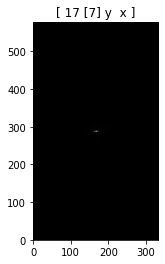

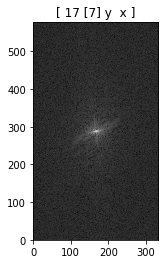

In [4]:
# Now let's look at the kspace

pl.ImagePlot(kspace) # Visualization of kspace in original space
pl.ImagePlot(kspace**0.2) # Visualization of kspace in approx. log scale (much better to visualize)

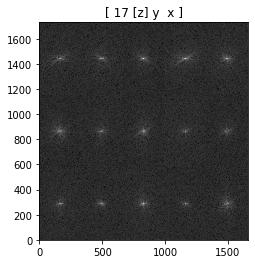

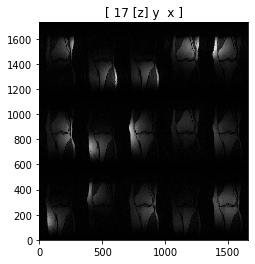

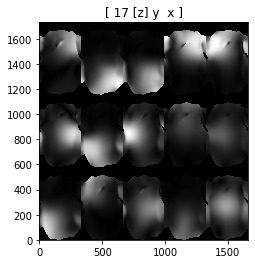

In [5]:
pl.ImagePlot(kspace**0.2, z=1) # Let's look at multi-coil kspace, z=1 means visualizing grid on the axis =1
# ith kspace corresponds to fft(true_image * coil_sensitivity_i) 

im_coil = sp.ifft(kspace, axes=(-1,-2)) # Let's ifft kspace to get coil image

pl.ImagePlot(im_coil, z=1) # Here now you can see each images correspond to true_image * coil_sensitivity
pl.ImagePlot(sens, z=1) # Look at the sensitivity map

RSS combined (35, 577, 332)


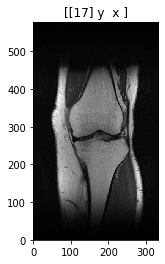

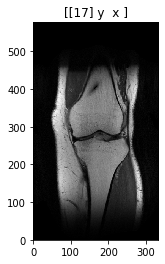

In [6]:
# there are mainly two ways to combine the multi-coil images
# 1. coils are designed to be symetrically distributed around the object, so usually root-sum-of squares can get sufficient estimates

im_rss = np.sqrt((im_coil * np.conj(im_coil)).sum(axis=1)) # np.conj because MR images are complex
print('RSS combined', im_rss.shape)
pl.ImagePlot(im_rss) 

# 2. Coil sensitivity maps can be scanned or estimated (i.e. ESPIRIT, JSENSE, etc.) and used to combine  

im_sense = np.sum(im_coil * np.conj(sens), axis=1)
pl.ImagePlot(im_sense) 

# (optional) Refer to https://users.fmrib.ox.ac.uk/~mchiew/docs/SENSE_tutorial.html, It's in MATLAB but covers SENSE reconstruction, gfactor maps

# Simulation of Undersampled acquisition

(1, 1, 1, 332)


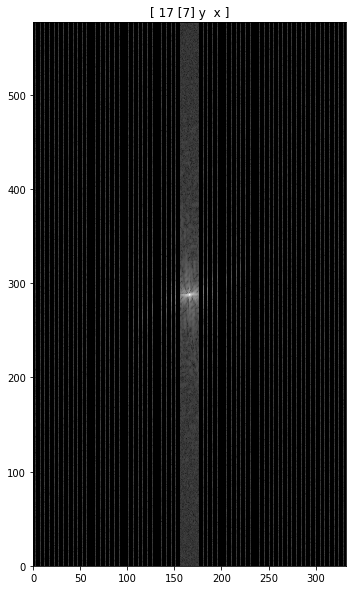

In [35]:
from fastmri.data import subsample

R = 4
mask_func = subsample.EquispacedMaskFunc(
                            center_fractions=[0.06],
                            accelerations=[R]) # This function generates an equispaced sampling mask generator
# help(subsample.EquispacedMaskFunc) # This is the description (uncomment this)

mask = mask_func(list(kspace.shape) + [1])[...,0] # trick because undersampling is in axis -1
mask = mask.numpy()
print(mask.shape)

kspace_us = kspace * mask 
pl.ImagePlot(kspace_us ** 0.2)


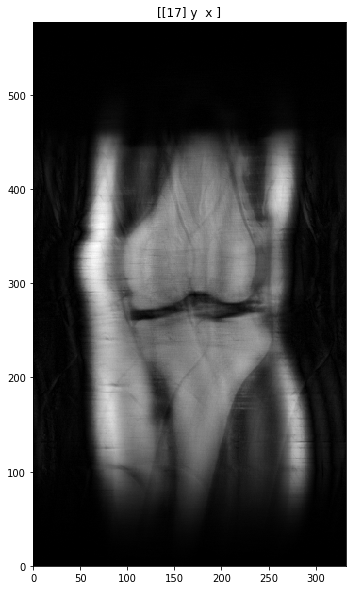

In [36]:
im_us_coil = sp.ifft(kspace_us, axes=(-1,-2)) # Let's try to reconstruct with the same process
im_us_sense = np.sum(im_us_coil * np.conj(sens), axis=1)

pl.ImagePlot(im_us_sense) # Now we get a weird aliased image

# Typically SENSE/GRAPPA (Parallel Imaging) method can recover x2 accelerations, 
# Parallel Imaging + Compressed Sensing (PI-CS) can recover x2-4 accelerations
# Deep Learning can recover up to x4-6 accelerations
# The final objective will be (im_us_sense + kspace_us + sensivitiy) ==> Deep Learning Recon ==> im_sense


In [ ]:
# For demonstration, let's look at PI-CS reconstruction method
# PI-CS method performs better with random-sampling so the result may be worse than it actually is
# Refer to https://github.com/mikgroup/sigpy-mri-tutorial/blob/master/03-building-an-l1-wavelet-recon-app.ipynb

PI-CS solves the following minimization problem:
$$\min_x \frac{1}{2} \| \underbrace{P F S }_{A} x - y \|_2^2 + \lambda \|W x \|_1$$
Where P is the sampling operator, F is the Fourier Transform operator, S is the sensitivity map operator, W is the wavelet transform operator


In [48]:
from sigpy.mri.app import L1WaveletRecon

y = kspace_us[17] # select 17th slice
mps = sens[17]

img = L1WaveletRecon(y,mps,lamda=0.05).run() # lamda is the regularizaition

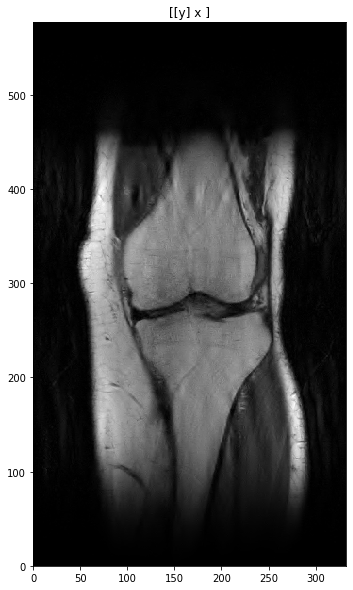

In [49]:
pl.ImagePlot(img) # This is the reconstructed result

In [ ]:
# Task to do : 1. How does the reconstructed image looks for different lambda values
# 2. What is the quantitative score (nRMSE, SSIM) for the above image? Can you calculate mean + std for the score for the images in Test 
# Please try this demo for other datasets and ask questions on Notion
